# [Machine Learning for Finance](https://www.datacamp.com/completed/statement-of-accomplishment/course/90f710ad9d5a202df55f0d7e24bdc95377ec8d1d)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/finance/machine_learning_for_finance/notebook.ipynb)

**Contents**
- [Data Preparation](#Data-Preparation)
- [Linear Regression](#Linear-Regression)
- [Tree-Based Models](#Tree-Based-Models)
- [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Neural Networks](#Neural-Networks)
- [Modern Portfolio Theory](#Modern-Portfolio-Theory)
- [Sharpe Ratio](#Sharpe-Ratio)


In [1]:
import talib
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeRegressor

BASE_URL = "https://raw.githubusercontent.com/adamelliotfields/datacamp/main/notebooks/finance/machine_learning_for_finance/"

warnings.filterwarnings("ignore", category=ConvergenceWarning)
pd.set_option("display.width", 400)

## Data Preparation

### EDA

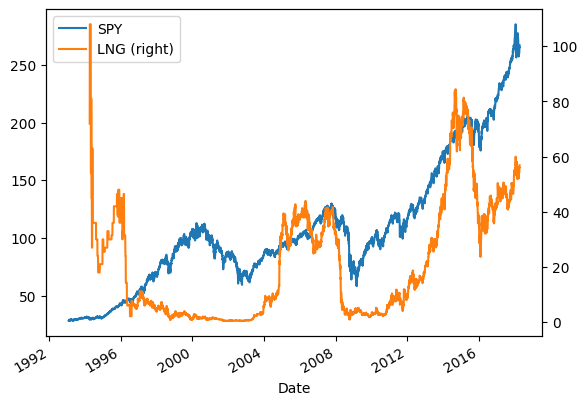

In [2]:
# load with datetime index
lng_df = pd.read_csv(BASE_URL + "LNG.csv", parse_dates=["Date"], index_col="Date")
spy_df = pd.read_csv(BASE_URL + "SPY.csv", parse_dates=["Date"], index_col="Date")

# plot adjusted close
spy_df["Adj_Close"].plot(label="SPY", legend=True)
lng_df["Adj_Close"].plot(label="LNG", legend=True, secondary_y=True)
plt.show()

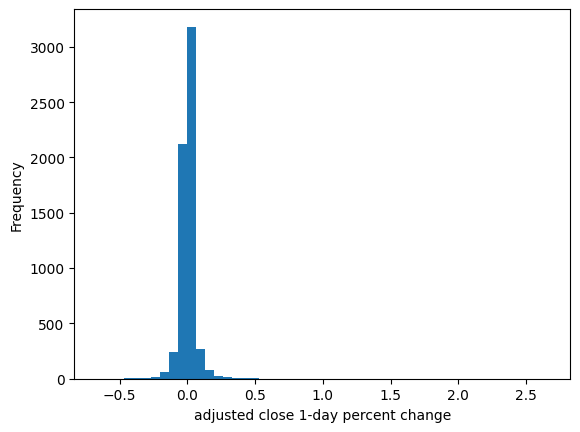

In [3]:
# plot percent change
lng_df["Adj_Close"].pct_change().plot.hist(bins=50)
plt.xlabel("adjusted close 1-day percent change")
plt.show()

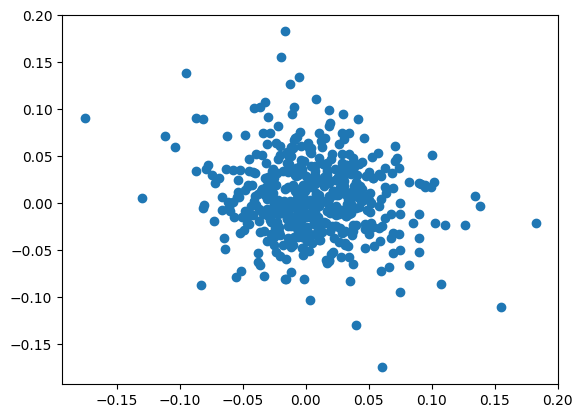

In [4]:
# start on 2016-04-15
lng_df = lng_df.loc["2016-04-15":]

# create 5-day future price and percent
lng_df["5d_future_close"] = lng_df["Adj_Close"].shift(-5)
lng_df["5d_close_future_pct"] = lng_df["5d_future_close"].ffill().pct_change(5)
lng_df["5d_close_pct"] = lng_df["Adj_Close"].ffill().pct_change(5)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df["5d_close_pct"], lng_df["5d_close_future_pct"])
plt.show()

### Feature Engineering

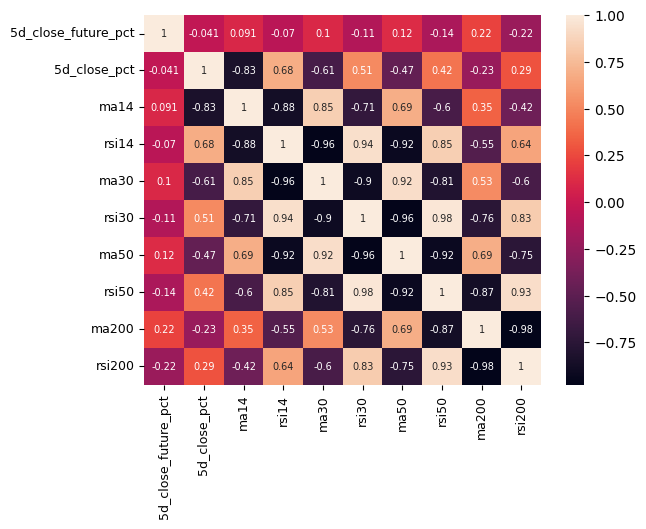

In [5]:
feature_names = ["5d_close_pct"]

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:
    # Create the moving average indicator and divide by Adj_Close
    lng_df["ma" + str(n)] = (
        talib.SMA(lng_df["Adj_Close"].values, timeperiod=n) / lng_df["Adj_Close"]
    )
    # Create the RSI indicator
    lng_df["rsi" + str(n)] = talib.RSI(lng_df["Adj_Close"].values, timeperiod=n)

    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ["ma" + str(n), "rsi" + str(n)]


# drop na
lng_df = lng_df.dropna()

# new dataframe
features = lng_df[feature_names]
targets = lng_df["5d_close_future_pct"]
feature_and_target_cols = ["5d_close_future_pct"] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# correlation matrix
corr = feat_targ_df.corr()
sns.heatmap(corr, annot=True, annot_kws={"size": 7})
plt.yticks(rotation=0, size=9)
plt.xticks(rotation=90, size=9)
plt.show()

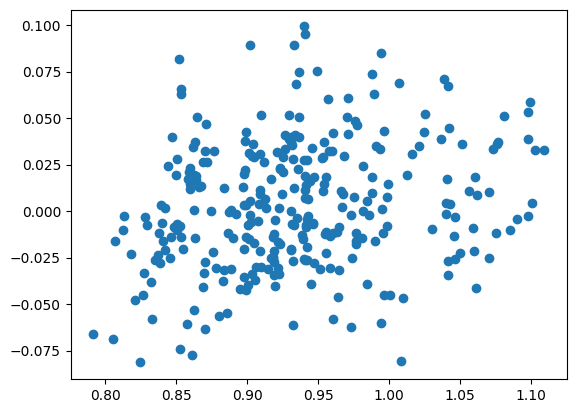

In [6]:
# scatter plot of ma200 vs 5d_close_future_pct
plt.scatter(lng_df["ma200"], lng_df["5d_close_future_pct"])
plt.show()

## Linear Regression

In [7]:
linear_features = sm.add_constant(features)

# 85/15 train/test split
train_size = int(0.85 * linear_features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]

# linear model with least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()

# summary
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.219
Model:                             OLS   Adj. R-squared:                  0.190
Method:                  Least Squares   F-statistic:                     7.591
Date:                 Thu, 04 Apr 2024   Prob (F-statistic):           8.30e-10
Time:                         16:35:24   Log-Likelihood:                 531.72
No. Observations:                  254   AIC:                            -1043.
Df Residuals:                      244   BIC:                            -1008.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.4733      1.209    

In [8]:
# p-values
print(results.pvalues)

const           1.997894e-07
5d_close_pct    6.518937e-01
ma14            3.701598e-02
rsi14           1.679457e-06
ma30            5.012731e-01
rsi30           6.274005e-07
ma50            2.392119e-03
rsi50           8.260452e-08
ma200           4.756815e-01
rsi200          2.721339e-09
dtype: float64


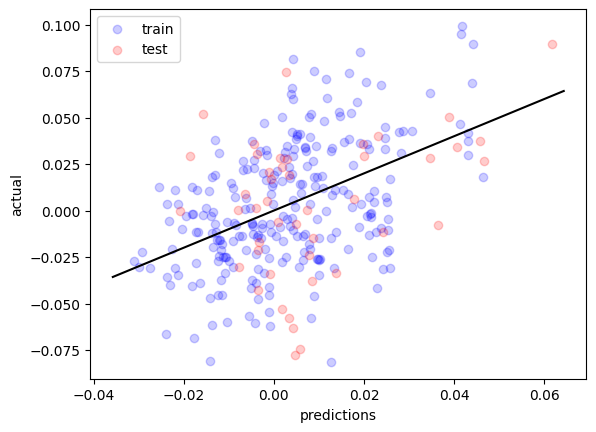

In [9]:
# make predictions
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

# evaluate
plt.scatter(train_predictions, train_targets, alpha=0.2, color="b", label="train")
plt.scatter(test_predictions, test_targets, alpha=0.2, color="r", label="test")
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c="k")
plt.xlabel("predictions")
plt.ylabel("actual")
plt.legend()
plt.show()

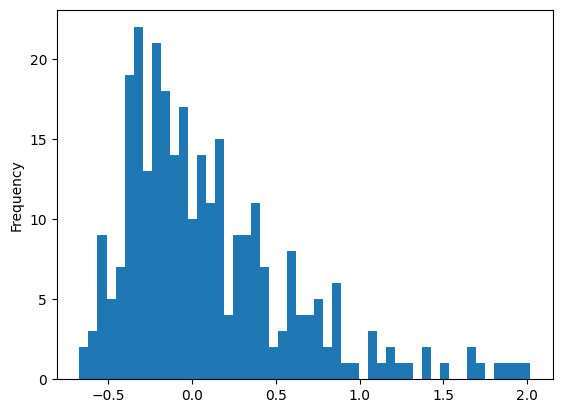

In [10]:
# create new volume features
feature_names = [
    "5d_close_pct",
    "ma14",
    "rsi14",
    "ma30",
    "rsi30",
    "ma50",
    "rsi50",
    "ma200",
    "rsi200",
]

new_features = ["Adj_Volume_1d_change", "Adj_Volume_1d_change_SMA"]
feature_names.extend(new_features)

lng_df[new_features[0]] = lng_df["Adj_Volume"].pct_change()
lng_df[new_features[1]] = talib.SMA(lng_df[new_features[0]].values, timeperiod=5)
lng_df = lng_df.dropna()

features = lng_df[feature_names]
targets = lng_df["5d_close_future_pct"]

train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

# plot
lng_df[new_features[0]].plot(kind="hist", bins=50, sharex=False)
plt.show()

## Tree-Based Models

A go-to model for data scientists is the Random Forest. It is an ensemble of _decision trees_, which have nodes that split the data based on features.

### Decision Trees

Decision trees use _purity_ to choose the best feature for splitting the data at each node. For categorical data, trees split on values being a certain category. For continuous data, trees split on values being above or below a certain threshold.

Once the tree has been created, it can be used to make predictions on new data. Each leaf node represents a subset of the training data. The tree predicts the average value of the target variable for the data in that leaf node. In simpler terms, the tree makes predictions by considering the outcomes of similar data points from the training data.

For regular decision trees, the most important hyperparameter is `max_depth`, which limits the number of splits. A tree that is too deep will overfit, while a shallow tree will be too simple and underfit.

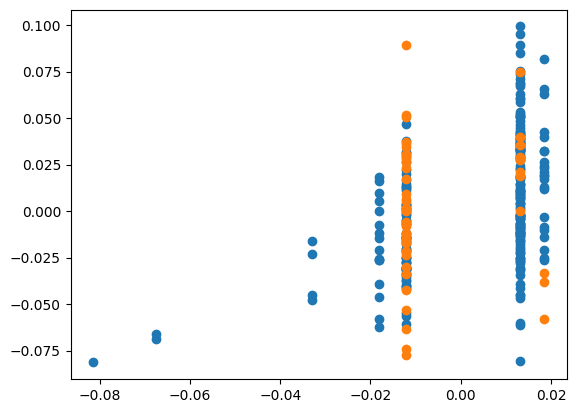

In [11]:
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# predictions group into lines
plt.scatter(train_predictions, train_targets, label="train")
plt.scatter(test_predictions, test_targets, label="test")
plt.show()

### Random Forests

_Random forests_ were created to reduce the variance of decision trees. The opposite of a high variance model is a high bias model, like a linear model, that captures the trend but misses the details. Random forests attempt to find a balance between bias and variance.

Random forests have differences in the way they grow trees. They use a technique called _bagging_, or _bootstrap aggregating_. Bootstrapping means sampling with replacement, so there can be repeated data points in the sample. Each tree in the forest is trained on a different bootstrap sample of the data, and the final prediction is the _aggregate_ of the predictions of all the trees.

Instead of considering all features at each split, random forests only consider a random subset of features. This is called _feature bagging_ and set by the `max_features` hyperparameter. The number of trees in the forest is set by the `n_estimators` hyperparameter.

In [12]:
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

grid = {
    "n_estimators": [200],
    "max_depth": [3],
    "max_features": [4, 8],
    "random_state": [42],
}
test_scores = []

for g in ParameterGrid(grid):
    rfr.set_params(**g)
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))


best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.05799366916997284 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


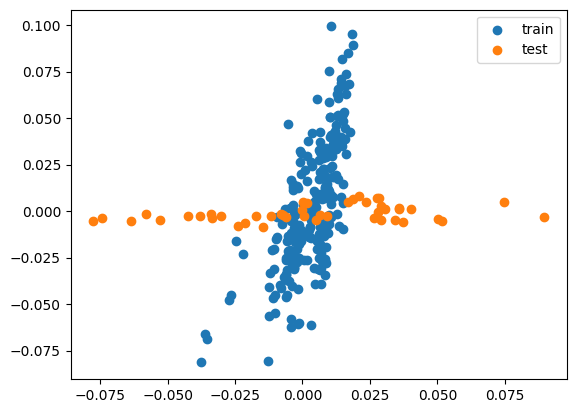

In [13]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# not good yet
plt.scatter(train_predictions, train_targets, label="train")
plt.scatter(test_targets, test_predictions, label="test")
plt.legend()
plt.show()

### Gradient Boosting

Rather than create a forest of trees, _gradient boosting_ creates a sequence of trees. Each tree is trained on the residual errors of the previous tree.

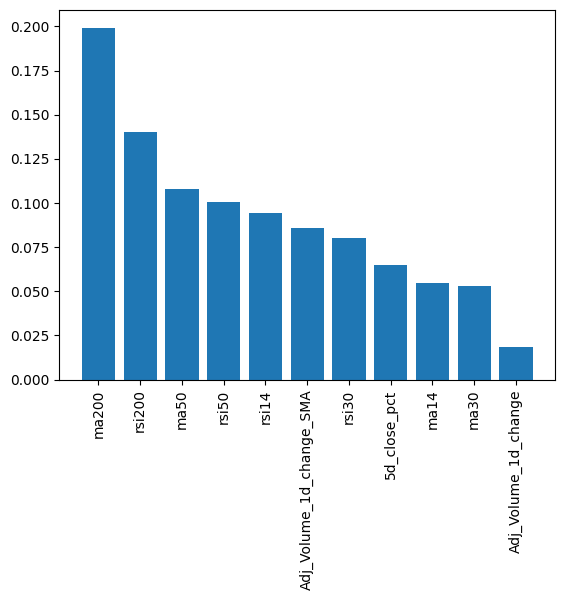

In [14]:
# get feature importances from the random forest
importances = rfr.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x = range(importances.shape[0])
labels = np.array(feature_names)[sorted_index]

plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

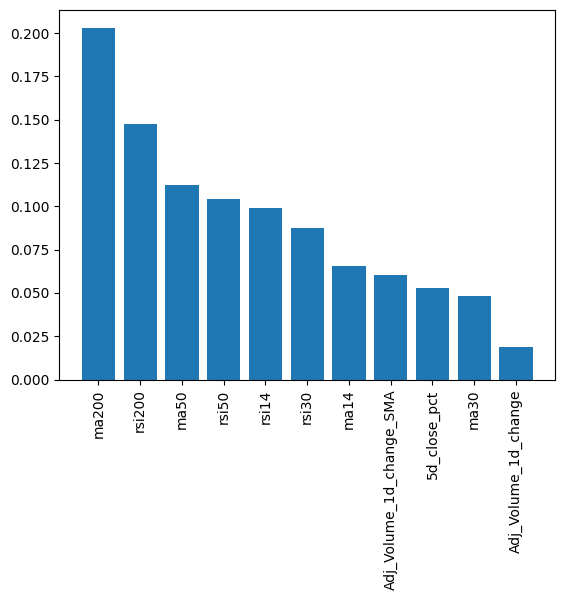

In [15]:
gbr = GradientBoostingRegressor(
    n_estimators=200,
    max_features=4,
    learning_rate=0.001,
    subsample=0.6,
    random_state=42,
)
gbr.fit(train_features, train_targets)

importances = gbr.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
labels = np.array(feature_names)[sorted_index]

plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

## K-Nearest Neighbors

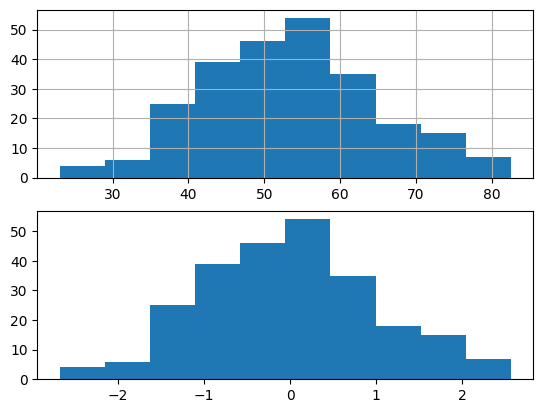

In [16]:
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

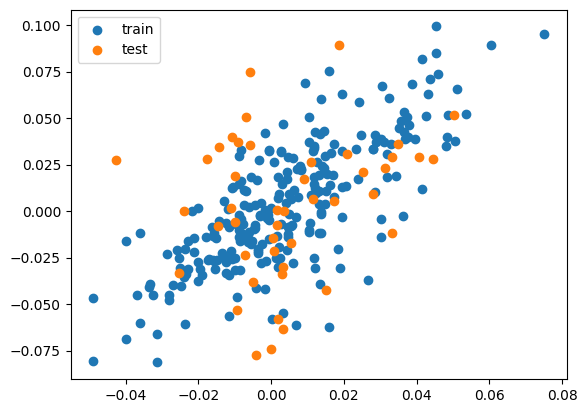

In [17]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(scaled_train_features, train_targets)

train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

plt.scatter(train_predictions, train_targets, label="train")
plt.scatter(test_predictions, test_targets, label="test")
plt.legend()
plt.show()

## Neural Networks

_Neural networks_ are similar to other models in that they take features and targets and output predictions. However, neural nets have the potential to outperform due to their non-linear nature and ability to capture complex patterns in the data (the interactions between features/variables).

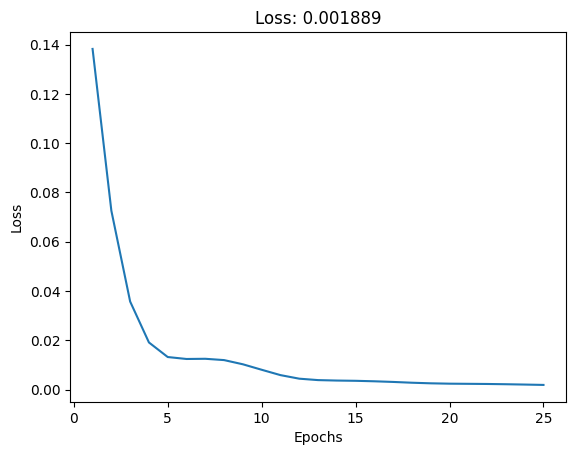

In [18]:
model = MLPRegressor(
    hidden_layer_sizes=(100, 20),
    activation="relu",
    solver="adam",
    max_iter=25,
    random_state=42,
)
model.fit(scaled_train_features, train_targets)

loss_curve = model.loss_curve_
epochs = np.arange(1, len(loss_curve) + 1)

plt.plot(epochs, loss_curve)
plt.title("Loss: " + str(round(loss_curve[-1], 6)))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

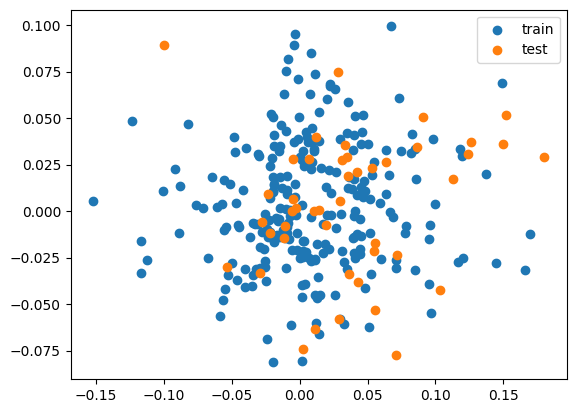

In [19]:
train_predictions = model.predict(scaled_train_features)
test_predictions = model.predict(scaled_test_features)

plt.scatter(train_predictions, train_targets, label="train")
plt.scatter(test_predictions, test_targets, label="test")
plt.legend()
plt.show()

## Modern Portfolio Theory

In [20]:
lng_df = pd.read_csv(BASE_URL + "LNG.csv", parse_dates=["Date"], index_col="Date")
spy_df = pd.read_csv(BASE_URL + "SPY.csv", parse_dates=["Date"], index_col="Date")
smlv_df = pd.read_csv(BASE_URL + "SMLV.csv", parse_dates=["Date"], index_col="Date")

# drop Adj_Volume
lng_df.drop("Adj_Volume", axis=1, inplace=True)
spy_df.drop("Adj_Volume", axis=1, inplace=True)
smlv_df.drop("Adj_Volume", axis=1, inplace=True)

# rename Adj_Close to the symbol
lng_df.rename(columns={"Adj_Close": "LNG"}, inplace=True)
spy_df.rename(columns={"Adj_Close": "SPY"}, inplace=True)
smlv_df.rename(columns={"Adj_Close": "SMLV"}, inplace=True)

full_df = pd.concat([lng_df, spy_df, smlv_df], axis=1).dropna()
monthly_df = full_df.resample("BMS").first()
returns_daily = full_df.pct_change()
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

                 LNG       SPY      SMLV
Date                                    
2017-12-01  0.019558  0.027069  0.029058
2018-01-01  0.128300  0.021450 -0.010725
2018-02-01  0.057770  0.047662 -0.003823
2018-03-01 -0.103353 -0.049293 -0.048131
2018-04-02  0.021396 -0.034367  0.009406


In [21]:
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           LNG       SPY      SMLV
LNG   0.000366  0.000192  0.000146
SPY   0.000192  0.000173  0.000127
SMLV  0.000146  0.000127  0.000103


In [22]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(10):
        weights = np.random.random(3)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)

print(portfolio_weights[date][0])

[0.02036505 0.09193178 0.88770317]


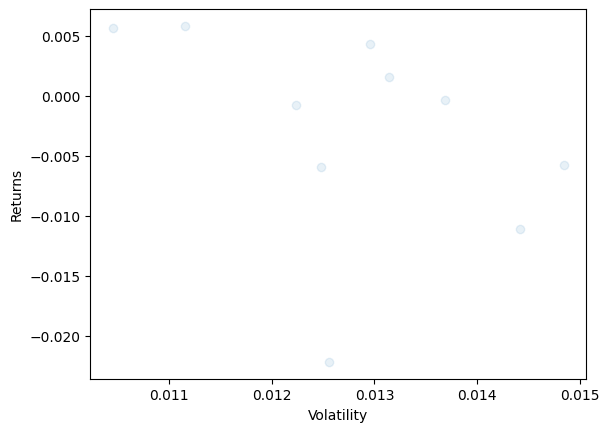

In [23]:
date = sorted(covariances.keys())[-1]
plt.scatter(portfolio_volatility[date], portfolio_returns[date], alpha=0.1)
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.show()

## Sharpe Ratio

In [24]:
sharpe_ratio, max_sharpe_idxs = {}, {}

for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.005625661392123573


In [25]:
ewma_daily = returns_daily.ewm(span=30).mean()
ewma_monthly = ewma_daily.resample("BMS").first()
ewma_monthly = ewma_monthly.shift(1).dropna()
print(ewma_monthly.iloc[-1])

LNG    -0.004304
SPY    -0.001003
SMLV   -0.001670
Name: 2018-04-02 00:00:00, dtype: float64


In [26]:
targets, features = [], []
for date in ewma_monthly.index:
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma_monthly.loc[date])

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[0.10853971 0.46988526 0.42157504]
 [0.33453753 0.66026457 0.0051979 ]
 [0.36703898 0.62325088 0.00971015]
 [0.09960963 0.77913256 0.12125782]
 [0.02036505 0.09193178 0.88770317]]


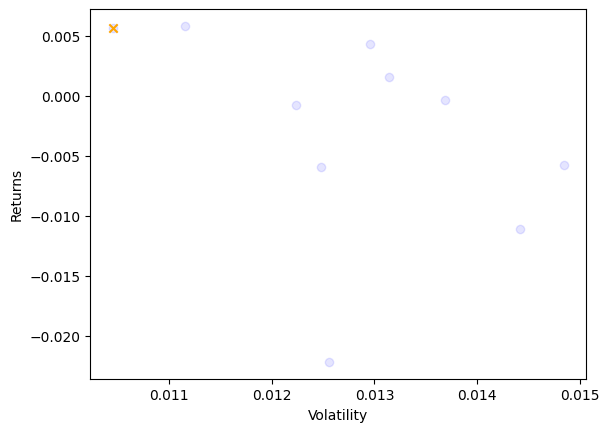

In [27]:
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color="blue")
best_idx = max_sharpe_idxs[date]

plt.scatter(
    x=cur_volatility[best_idx],
    y=cur_returns[best_idx],
    color="orange",
    marker="x",
)
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.show()

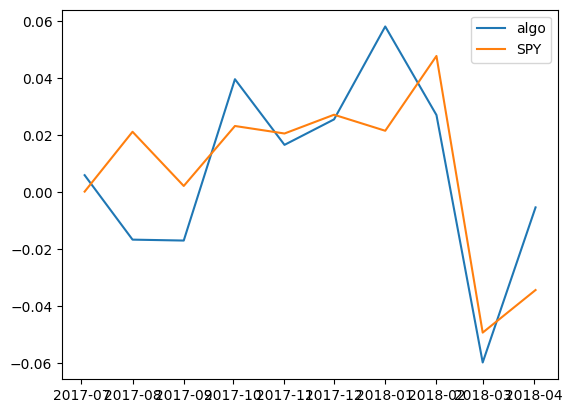

In [28]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)

train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)

plt.plot(test_returns, label="algo")
plt.plot(returns_monthly["SPY"].iloc[train_size:], label="SPY")
plt.legend()
plt.show()

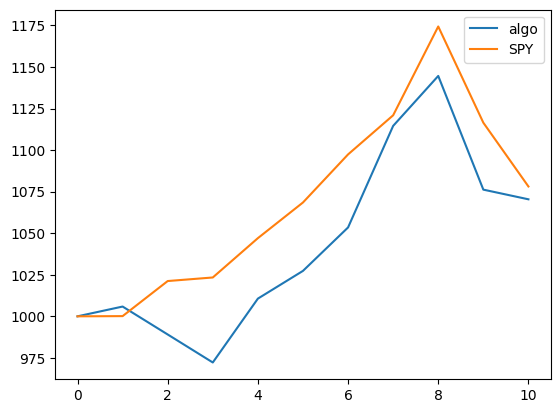

In [29]:
cash = 1000
algo_cash, spy_cash = [cash], [cash]
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

cash = 1000
for r in returns_monthly["SPY"].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

plt.plot(algo_cash, label="algo")
plt.plot(spy_cash, label="SPY")
plt.legend()
plt.show()